In [11]:
%matplotlib inline
import numpy as np
from scipy.constants import e
import matplotlib.pyplot as plt
from IPython.display import clear_output
import ocelot as oclt

from chimera.moduls.species import Specie
from chimera.moduls.solvers import Solver
from chimera.moduls.chimera_main import ChimeraRun
from chimera.moduls.diagnostics import Diagnostics
from chimera.moduls import fimera as chimera

As a simplest test, we consider a 20 $\mu$m drift of a 30 pC electron beam with the gaussian density profiles $\sigma_z=\sigma_r=3$ $\mu$m, with the longitudinal momentum $p_z=50\, m_e c $. Initially beam has no energy spread and zero divergence.

In [12]:
SimLgth = 100.
pz0 = 50.
Chrg = 30e-12
Size = 3.

nmax = Chrg/e/((Size*1.e-4)**3*(2*np.pi)**1.5)/(1.1e21)

## OCELOT simulation

In [13]:
Np = int(5e5)
BeamCharge = Chrg
parts0 = np.zeros((6,Np))

parts0[0] = Size*1e-6*np.random.randn(Np)
parts0[2] = Size*1e-6*np.random.randn(Np)
parts0[4] = Size*1e-6*np.random.randn(Np)
p_array_init = oclt.ParticleArray()
p_array_init.particles = parts0.T.flatten()
p_array_init.E = (1+pz0**2)**.5*0.511e-3
p_array_init.s = 0.0
p_array_init.q_array = (BeamCharge/Np)*np.ones(Np)

D1  = oclt.Drift(l = SimLgth*1e-6 )
D2  = oclt.Drift(l=0)
cell = (D1,D2)

sc1 = oclt.SpaceCharge()
sc1.nmesh_xyz = [63, 63, 63]
sc1.low_order_kick = False
sc1.step = 1

method = oclt.MethodTM()
lat = oclt.MagneticLattice(cell,method=method)
print("length of the cell: ", lat.totalLen, "m")

navi = oclt.Navigator(lat)
navi.add_physics_proc(sc1,lat.sequence[0],lat.sequence[-1])

('length of the cell: ', 9.999999999999999e-05, 'm')


In [14]:
p_array = oclt.deepcopy(p_array_init)

dz = 1e-6
LL = p_array.s
SS  = []
Sx  = []
Sy  = []
Sz  = []
Ex = []
Ey = []

while LL<lat.totalLen:
    oclt.tracking_step(lat, p_array, dz,navi)
    proc_list = navi.get_proc_list()
    for p in proc_list:
        p.z0 = navi.z0
        p.apply(p_array, dz)
    LL += dz
    clear_output(wait=True)
    print LL,'/',lat.totalLen

0.000101 / 0.0001


## CHIMERA with solver in "StaticKick" mode

In [15]:
xmin, xmax = -7.*Size,7.*Size
lrg = 30*Size
Nx = 300
Nr = 300

dx = (xmax-xmin)/Nx
dr = lrg/Nr
dt = 0.16

solver_in = {
    'Grid':(xmin, xmax,lrg,dx,dr),'TimeStep':dt,'MaxAzimuthMode':1,
    'Features':('StaticKick',),'Xchunked':(4,6)
}

beam_in = {
    'Grid':(xmin, xmax,lrg,dx,dr),'TimeStep':dt,'Charge':-1.,'Mass':1.,
    'Density':nmax, 'FixedCell':(8,8,8),'MomentaMeans':(pz0,0.,0.),
    'Features':('NoSorting',),'Xchunked':(4,6)
    
}

solver = Solver(solver_in)
beam = Specie(beam_in)

MovingFrame = {'TimeStep':dt,'Steps':5,'Features':('Staged',),'AbsorbLayer':0}

chimera_in = {
    'Solvers':(solver,),'Particles':(beam,),'MovingFrames':(MovingFrame,)
}

fu = lambda x,y,z: np.exp(-0.5*(x**2+y**2+z**2)/Size**2)
#beam.add_particles(beam.gen_parts(Domain=(-3.5*Size,3.5*Size, 0.0, 3.5*Size),ProfileFunc=fu))

#"""
beam.particles = np.zeros((8,Np))
beam.particles[0] = -p_array_init.tau()*1e6
beam.particles[1] = p_array_init.y()*1e6
beam.particles[2] = p_array_init.x()*1e6

beam.particles[4] = p_array_init.py()*p_array_init.E/0.511e-3
beam.particles[5] = p_array_init.px()*p_array_init.E/0.511e-3

beam.particles[6] = (p_array_init.p()+1)*p_array_init.E/0.511e-3
beam.particles[3] =  np.sqrt(beam.particles[6]**2-1)

beam.particles[7] = -p_array_init.q_array/beam.weight2pC*1e12
beam.particles_cntr = beam.particles[:3].copy()
#"""

Chimera = ChimeraRun(chimera_in)
Diags = Diagnostics(Chimera,(),out_folder=None)
Chimera.make_halfstep()

Constructing a solver in the cylindric box (-21.0, 21.0, 90.0)
spatial and temporal resolutions are (0.14, 0.3, 0.16)
Grid resolutions are  (304, 300, 2)
Space charge is added
adding inits


63.0956366709 1591.39460689


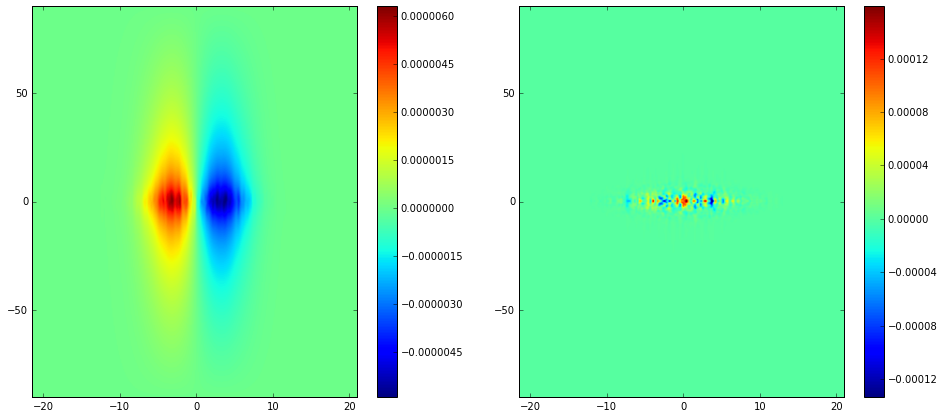

In [16]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,7),dpi=200)

extent = (solver.Args['Xgrid'].min(),solver.Args['Xgrid'].max(),
          -solver.Args['Rgrid'].max(),solver.Args['Rgrid'].max())

ee = Diags.fld_out( {'Features':('Return',)} )[0]
nn = Diags.dns_out( {'Features':{'Return':0,'MaxMode':1}} )[0]

ex =  np.real(np.hstack((ee[:,::-1,0,0] + ee[:,::-1,1,0],ee[:,1:,0,0] -ee[:,1:,1,0])))
ey =  np.real(np.hstack((ee[:,::-1,0,1] - ee[:,::-1,1,1],ee[:,1:,0,1] +ee[:,1:,1,1])))
bz =  np.real(np.hstack((ee[:,::-1,0,5] + ee[:,::-1,1,5],ee[:,1:,0,5] -ee[:,1:,1,5])))
ne =  np.real(np.hstack((nn[:,::-1,0] + nn[:,::-1,1],nn[:,1:,0] -nn[:,1:,1])))

pl1 = ax1.imshow(ex.T ,aspect='auto', extent=extent,origin='lower')
pl2 = ax2.imshow((ey+bz).T ,aspect='auto', extent=extent,origin='lower')

fig.colorbar(pl1,ax=ax1)
fig.colorbar(pl2,ax=ax2)

print ex.max()*1e7,(ey+bz).max()*1e7

In [17]:
for i in range(int(SimLgth/dt)+1):
    Chimera.make_step(i)
    clear_output(wait=True)
    print i,'/',int(SimLgth/dt)

625 / 625


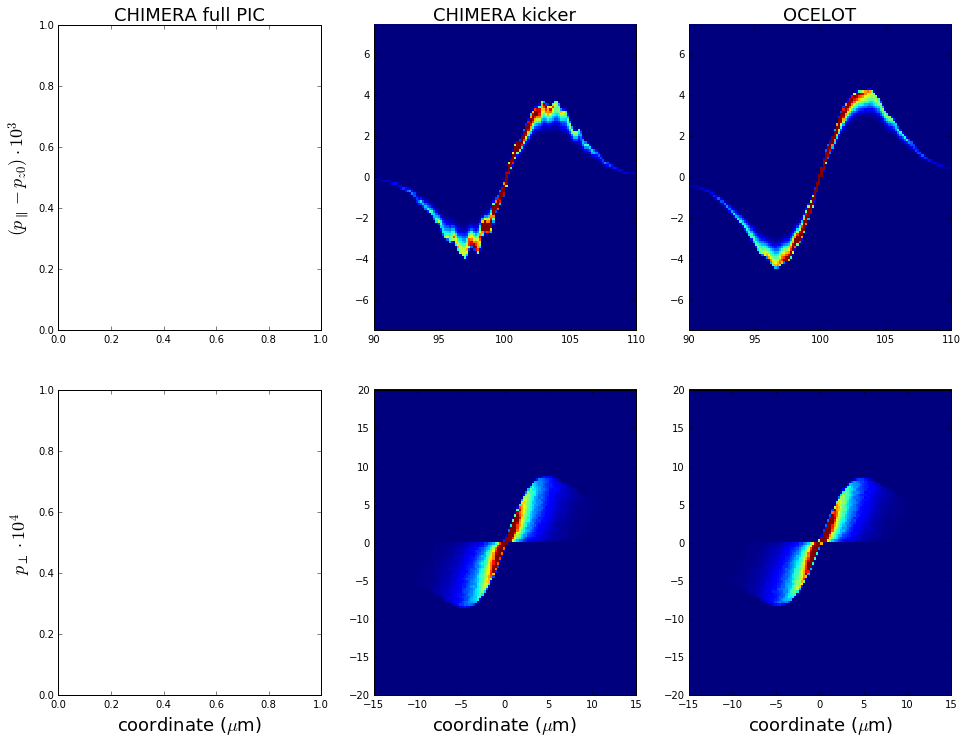

In [18]:
fig,((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3,dpi=200,figsize=(16,12),)

dpmax = (beam.particles[3].max()-pz0)*1e3
range1 = [[SimLgth-10,SimLgth+10],[-2*dpmax,+2*dpmax]]
range2=[[-15,15],[-20,20]]

ax2.hist2d(beam.particles[0],(beam.particles[3]-pz0)*1e3,weights=-beam.particles[-1],
           bins=120,range=range1,vmax=5e-4);
ax3.hist2d((-p_array.tau()+p_array.s)*1e6,(p_array.p())*p_array.E*1e6/0.511,weights=p_array.q_array,
           bins=120,range=range1,vmax=5e-4*beam.weight2pC*1e-12);

ax5.hist2d(beam.particles[2],beam.particles[5]*1e4,weights=-beam.particles[-1],
           bins=120,range=range2,vmax=5e-4);
ax6.hist2d(p_array.x()*1e6,p_array.px()*p_array.E*1e7/0.511,weights=p_array.q_array,
           bins=120,range=range2,vmax=5e-4*beam.weight2pC*1e-12);

ax1.set_title('CHIMERA full PIC',fontsize=18);
ax2.set_title('CHIMERA kicker',fontsize=18)
ax3.set_title('OCELOT',fontsize=18)

for ax in (ax4,ax5,ax6): ax.set_xlabel('coordinate ($\mu$m)',fontsize=18)
ax1.set_ylabel('$(p_\parallel-p_{z0})\cdot 10^3$',fontsize=18)
ax4.set_ylabel('$p_\perp\cdot 10^4$',fontsize=18)